# Exploración de la data

In [1]:
# importamos las librerías a utilizar
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve,roc_curve,confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier, plot_importance

## Configuracion de las rutas para lograr las importaciones

In [2]:
import sys
import os

# obtiene la ruta absoluta del directorio 'src' desde la ubicación del notebook
src_path = os.path.abspath(os.path.join('..', 'src'))

# agrega la ruta a 'src' al sys.path si no está ya presente
if src_path not in sys.path:
    sys.path.append(src_path)

## Cargamos los datos

In [3]:
from utils import load_data, ReadCsvParams, SaveCsvParams # type: ignore

file_path = '../data/raw/hotel_booking.csv'
url = 'https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv'
read_csv_params: ReadCsvParams = {'delimiter': ','}
save_csv_params: SaveCsvParams = {'sep': ','}

df_hotel: pd.DataFrame = load_data(
    file_path=file_path, url=url, read_csv_params=read_csv_params, save_csv_params=save_csv_params
)

Loading data from file: ../data/raw/hotel_booking.csv


Ahora procedemos a ver la información general de los datos

In [4]:
# Convertir a minúsculas los valores de columnas categóricas
for col in df_hotel.select_dtypes(include=['object', 'category']).columns:
    df_hotel[col] = df_hotel[col].str.lower()

# Mostramos para chequear
df_hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,resort hotel,0,342,2015,july,27,1,0,0,2,...,transient,0.0,0,0,check-out,01/07/2015,ernest barnes,ernest.barnes31@outlook.com,669-792-1661,************4322
1,resort hotel,0,737,2015,july,27,1,0,0,2,...,transient,0.0,0,0,check-out,01/07/2015,andrea baker,andrea_baker94@aol.com,858-637-6955,************9157
2,resort hotel,0,7,2015,july,27,1,0,1,1,...,transient,75.0,0,0,check-out,02/07/2015,rebecca parker,rebecca_parker@comcast.net,652-885-2745,************3734
3,resort hotel,0,13,2015,july,27,1,0,1,1,...,transient,75.0,0,0,check-out,02/07/2015,laura murray,laura_m@gmail.com,364-656-8427,************5677
4,resort hotel,0,14,2015,july,27,1,0,2,2,...,transient,98.0,0,1,check-out,03/07/2015,linda hines,lhines@verizon.com,713-226-5883,************5498


In [5]:
# Mostramos información básica
df_hotel.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [6]:
# Mostramos información básica
df_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Eliminamos la data a no utilizar

Eliminaremos las siguientes columnas ya que es data que no apoyara al modelo.

In [7]:
# Eliminamos columnas que no aportan
columnas_a_eliminar = ['name', 'email', 'phone-number', 'credit_card', 'company', 'reservation_status', 'reservation_status_date', 'agent']
df_hotel.drop(columns=columnas_a_eliminar, inplace=True)

In [8]:
print("\nColumnas luego de eliminar las que no sirven:")
pd.DataFrame(df_hotel.columns, columns=['Columnas eliminadas'])


Columnas luego de eliminar las que no sirven:


,Columnas eliminadas
0,hotel
1,is_canceled
2,lead_time
3,arrival_date_year
4,arrival_date_month
5,arrival_date_week_number
6,arrival_date_day_of_month
7,stays_in_weekend_nights
8,stays_in_week_nights
9,adults


## Eliminamos los valores nulos

Estudiamos los valores nulos para cada columna.

In [9]:
# Ahora analizamos los valores nulos
print("\nCantidad de valores nulos por columna:")
cantidad_nulos = pd.DataFrame(df_hotel.isnull().sum(), columns=['Cantidad de nulos'])
cantidad_nulos[cantidad_nulos['Cantidad de nulos'] > 0]


Cantidad de valores nulos por columna:


,Cantidad de nulos
children,4
country,488


In [10]:
# Para ver también en porcentaje (opcional)
print("\nPorcentaje de valores nulos por columna:")
porcentaje_nulos = pd.DataFrame((df_hotel.isnull().sum() / len(df_hotel)) * 100, columns=['Porcentaje de nulos'])
porcentaje_nulos = porcentaje_nulos[porcentaje_nulos['Porcentaje de nulos'] > 0].map(lambda x: f'{x:.3f}%')
porcentaje_nulos


Porcentaje de valores nulos por columna:


,Porcentaje de nulos
children,0.003%
country,0.409%


## Columnas sobre las que trabajar y sus tipo

Guardamos las columnas de cada tipo para poder trabajar mas fácil

In [11]:
# variable objetivo
target: str = 'is_canceled'

# columnas numéricas
col_numericas: list[str] = ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']

# columnas categoricas
col_categoricas: list[str] = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']

# features
features = col_numericas + col_categoricas

# agrega a las columnas categoricas la variable objetivo
col_categoricas = col_categoricas + [target]

## Graficos De Análisis

### Analisis de la variable objetivo

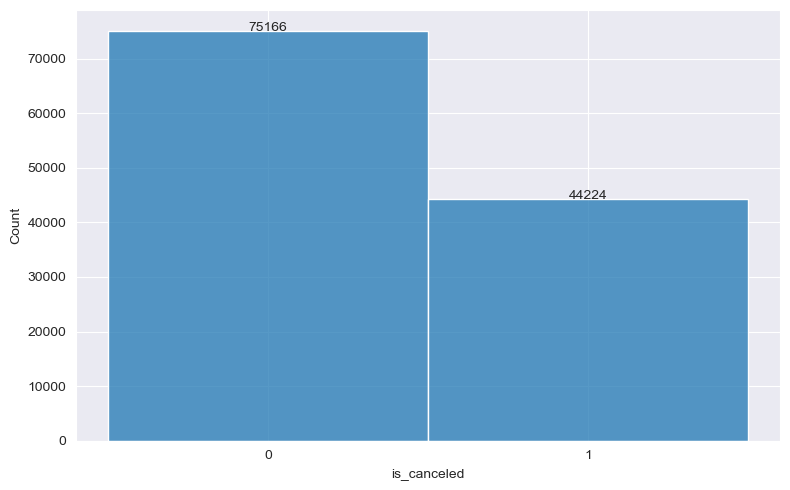

In [12]:
fig, axis = plt.subplots(1, 1, figsize=(8, 5))

# graph the amount of each label
ax = sns.histplot(data=df_hotel, x="is_canceled", discrete=True)


# add the value of each bin on top of the bar
for p in ax.patches:
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=p.get_height() + 0.1,
        s=f'{int(p.get_height())}',
        ha='center'
    )

# set the x-axis ticks to 0 and 1
plt.xticks([0, 1])

# adjust the layout
plt.tight_layout()

# show the plot
plt.show()

Donde 0 es que la reserva no fue cancelada y 1 es que la reserva fue cancelada. Podemos ver que la data está desbalanceada, con mayor cantidad de data para los labels 0 (reservas no canceladas).

### Analisis de la variable objetivo contra las features(target)

Estudiamos la relación de la variable objetivo con las demás variables

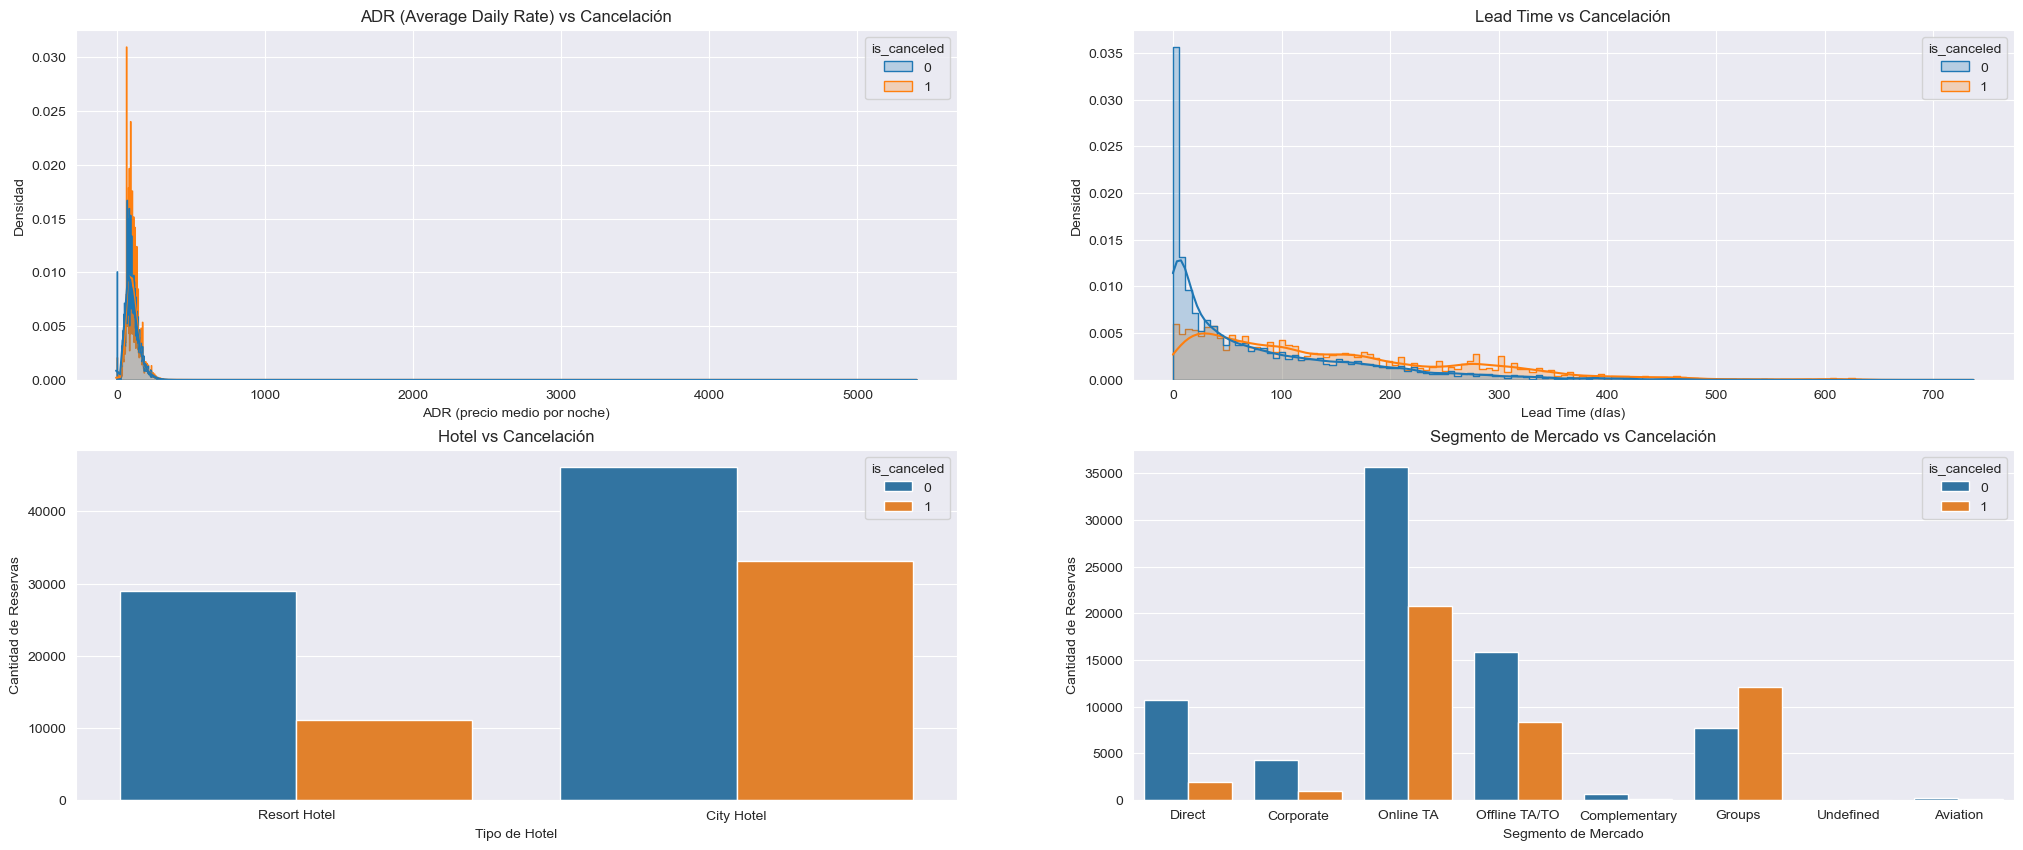

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

_, axis = plt.subplots(2, 2, figsize=(25, 10))

# 1. adr vs. cancelación (histograma)
sns.histplot(data=df_hotel, x='adr', hue='is_canceled', kde=True, element="step", stat="density", common_norm=False, ax=axis[0, 0]).set(
    title='ADR (Average Daily Rate) vs Cancelación',
    xlabel='ADR (precio medio por noche)',
    ylabel='Densidad',
)
# plt.xlim(0, 500)  # Limitar para que los outliers extremos no deformen el gráfico
# plt.legend(title='Cancelada', labels=['No', 'Sí'])


# 2. lead_time vs. cancelación (histograma)
sns.histplot(data=df_hotel, x='lead_time', hue='is_canceled', kde=True, element="step", stat="density", common_norm=False, ax=axis[0, 1]).set(
    title='Lead Time vs Cancelación',
    xlabel='Lead Time (días)',
    ylabel='Densidad',
)
# plt.legend(title='Cancelada', labels=['No', 'Sí'])


# 3. hotel vs. cancelación
sns.countplot(data=df_hotel, x='hotel', hue='is_canceled', ax=axis[1, 0]).set(
    title='Hotel vs Cancelación',
    xlabel='Tipo de Hotel',
    ylabel='Cantidad de Reservas',
)
# plt.legend(title='Cancelada', labels=['No', 'Sí'])


# 4. market_segment vs. cancelación
sns.countplot(data=df_hotel, x='market_segment', hue='is_canceled', ax=axis[1, 1]).set(
    title='Segmento de Mercado vs Cancelación',
    xlabel='Segmento de Mercado',
    ylabel='Cantidad de Reservas',
)
# plt.legend(title='Cancelada', labels=['No', 'Sí'])
# plt.xticks(rotation=45)

plt.show()

### Matriz de correlación

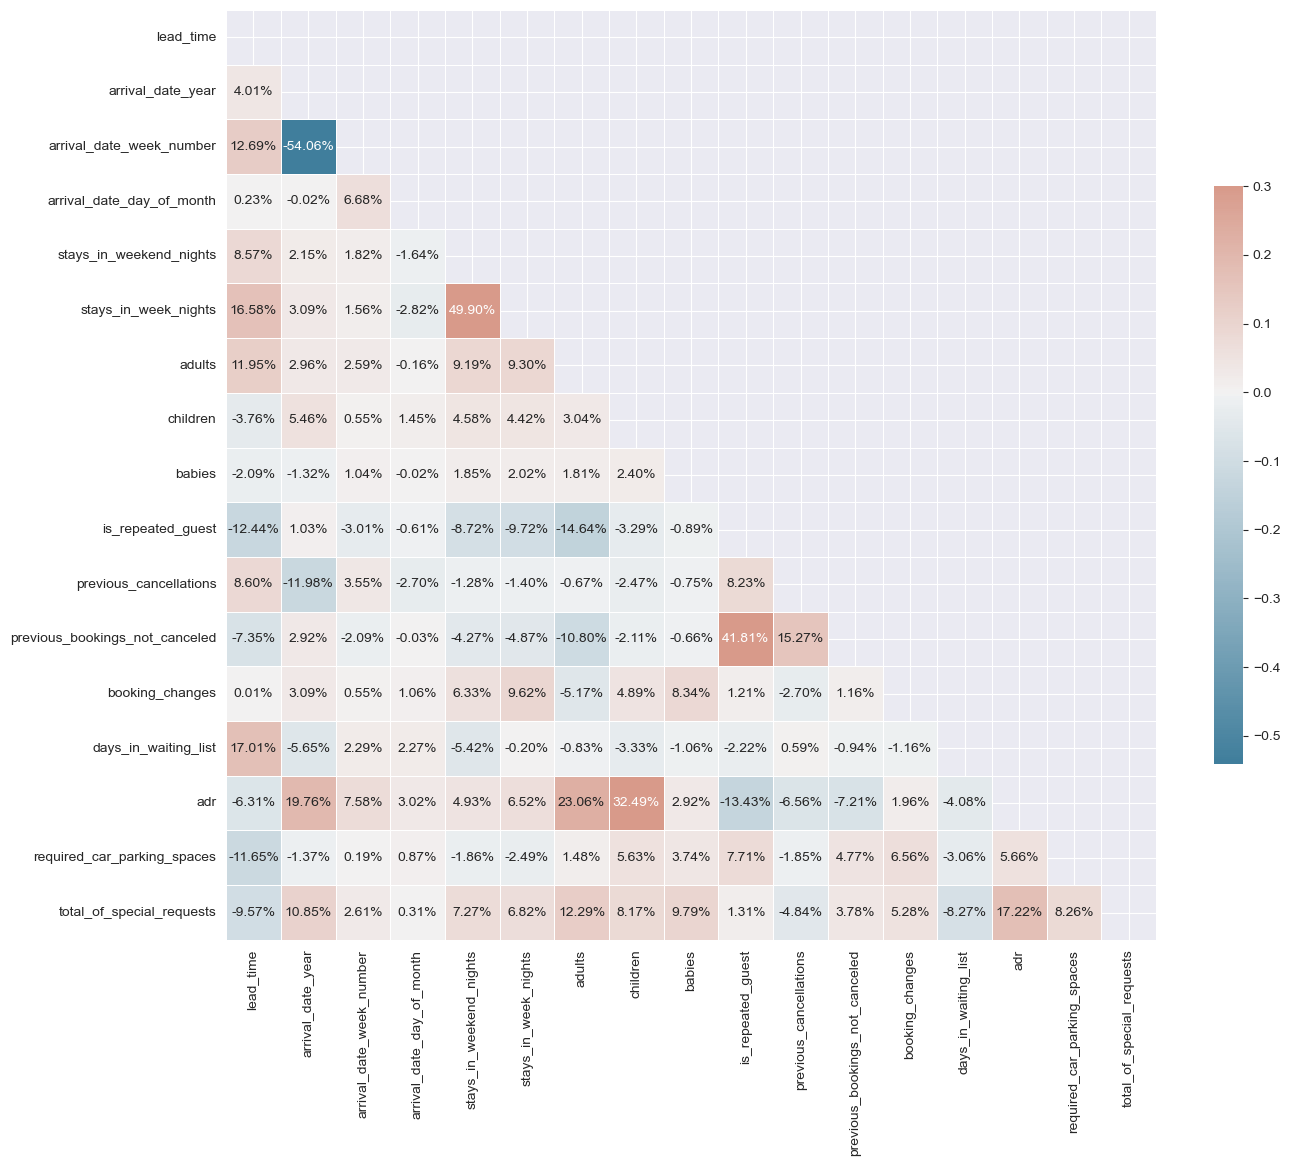

In [14]:
from draw_utils import draw_corr_matrix # type: ignore


# crea la matriz de correlación de las variables numericas
corr = df_hotel[col_numericas].corr()

# dibuja la matriz de correlación
draw_corr_matrix(corr=corr, fig_size=(15, 15))

Podemos observar alta correlacion positiva y negativa entre varias variables, siendo las de mayor correlacion:

- stays_in_week_nights y stays_in_weekend_nights **(positiva)**
- previous_bookings_not_canceled y children **(positiva)**
- adr y is_repeated_guest **(positiva)**
- arrival_date_week_number y arrival_date_year **(negativa)**
- is_repeated_guest y adults **(negativa)**

## Guardamos los datos pre-procesados

In [15]:
# definimos la ruta
ruta_pre_procesado = '../data/processed/hotel_booking.csv'
try:
    # save the DataFrame to the file for future use
    df_hotel.to_csv(ruta_pre_procesado, index=False, sep=save_csv_params["sep"])

    print(f"Data saved to file: {ruta_pre_procesado}")

except Exception as e:
    print(f"Error saving data to {ruta_pre_procesado} with error: {e}")

Data saved to file: ../data/processed/hotel_booking.csv


# Estudio de un modelo básico

Vamos a hacer un análisis de un modelo básico para verificar que la elección del mismo puede dar solución al problema.

## Separamos los datos en entrenamiento y prueba

In [16]:
from sklearn.model_selection import train_test_split


# Toma las variables y el target
X = df_hotel.drop(columns=target)
y = df_hotel[target]

# divide the dataset into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Aplicamos el one hot encoder a las columnas categoricas

In [17]:
from sklearn.preprocessing import OneHotEncoder

# definimos las columnas a codificar
cols_to_encode: list[str] = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']

# inicializamos el OneHotEncoder
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# ajustamos el OneHotEncoder a las columnas categóricas del conjunto de entrenamiento
onehot_encoder.fit(X_train[cols_to_encode])

# transformamos los conjuntos de entrenamiento y prueba
X_train_encoded = onehot_encoder.transform(X_train[cols_to_encode])
X_test_encoded = onehot_encoder.transform(X_test[cols_to_encode])

In [18]:
# obtenemos los nombres de las nuevas columnas creadas
feature_names = onehot_encoder.get_feature_names_out(cols_to_encode)

# creamos DataFrames con las columnas codificadas
train_encoded_df = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
test_encoded_df = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)

In [19]:
# Concatenar las columnas codificadas con los DataFrames originales (excluyendo las columnas originales)
X_train_final = pd.concat([X_train.drop(columns=cols_to_encode), train_encoded_df], axis=1)
X_test_final = pd.concat([X_test.drop(columns=cols_to_encode), test_encoded_df], axis=1)

In [20]:
# imprimimos para verificar
X_train_final

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,...,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
105447,20,2017,6,7,0,2,1,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
85242,8,2016,11,9,0,3,2,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
65604,93,2017,14,6,0,3,2,0.0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
17345,90,2015,39,23,4,10,2,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
117786,8,2017,32,9,0,1,1,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104906,22,2017,3,19,2,4,1,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
50818,18,2016,20,9,1,2,1,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
36939,135,2017,22,30,0,3,2,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
14587,172,2017,24,14,2,5,2,0.0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
# imprimimos para verificar
X_test_final

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,...,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
93581,14,2016,30,21,0,2,2,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
115055,6,2017,26,30,0,1,2,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
56243,120,2016,36,1,1,3,2,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
38448,0,2017,29,18,0,0,2,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
87074,138,2016,16,13,0,1,2,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90621,43,2016,24,8,0,1,1,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
52322,177,2016,23,3,0,2,2,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
99579,105,2016,42,12,0,3,2,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39838,125,2017,35,28,1,1,2,2.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Guardamos el OneHotEncoder

In [22]:
from pickle import dump

encoder_file_name = '../models/one_hot_encoder.pkl'

with open(encoder_file_name, "wb") as f:
    dump(onehot_encoder, f, protocol=5)

## Guardamos los datos pre-procesados, codificados y separados en entrenamiento y prueba

In [23]:
from constants import X_TRAIN_PATH, X_TEST_PATH, Y_TRAIN_PATH, Y_TEST_PATH

# save the processed data to their corresponding files
X_train_final.to_csv(path_or_buf=X_TRAIN_PATH, sep=',', index=False, )
X_test_final.to_csv(path_or_buf=X_TEST_PATH, sep=',', index=False, )

y_train.to_csv(path_or_buf=Y_TRAIN_PATH, sep=',', index=False, )
y_test.to_csv(path_or_buf=Y_TEST_PATH, sep=',', index=False, )


## Entrenamiento del modelo XGBoost

In [24]:
import xgboost as xgb


# Inicializamos el modelo
model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

# Entrenamiento
model.fit(X_train_final, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Evaluación del modelo

In [25]:
# Predicciones y evaluación
y_pred = model.predict(X_test_final)

In [26]:
y_proba = model.predict_proba(X_test_final)[:, 1]

### Matriz de confusion


Matriz de confusion:


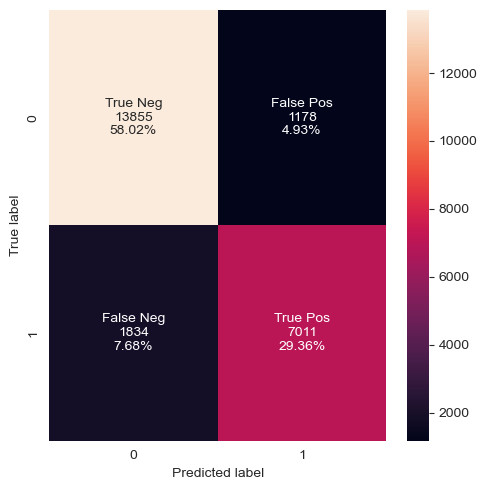

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
from draw_utils import draw_confusion_matrix # type: ignore


# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusion:")
draw_confusion_matrix(conf_matrix)


Interpretación rápida:

- True Neg  **(13855)** → Reservas no canceladas predichas correctamente.
- True Pos  **(7011)** → Cancelaciones correctamente detectadas.
- False Pos **(1178)** → Predijo cancelación, pero la reserva no fue cancelada.
- False Neg **(1834)** → No predijo cancelación, pero sí se canceló.

Con base en estos números, el modelo está haciendo un trabajo razonable, pero hay margen de mejora en los falsos negativos si nuestro objetivo es minimizar el **churn** (posibilidad de que alguien siga con el servicio).

### Metrica ROC AUC

Hacemos el estudio de la metrica ROC AUC para verificar el desempeno del modelo. Se sekecciona esta metrica para el estudio debido a que la data se encuentra desbalanceada.

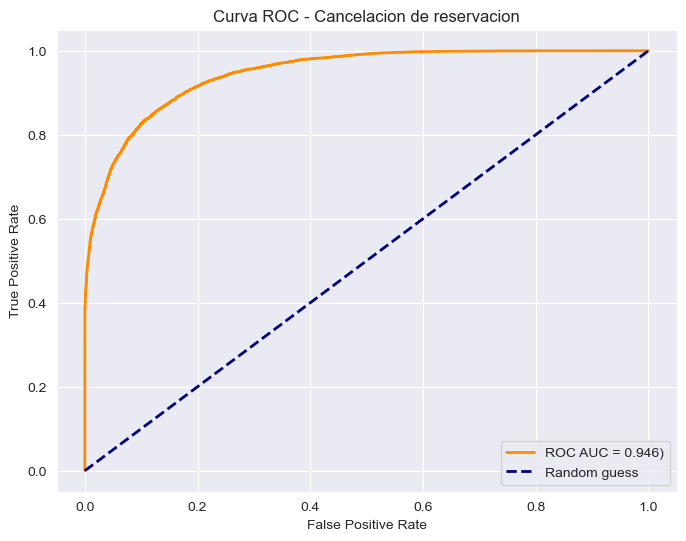

In [28]:
from draw_utils import draw_roc_auc # type: ignore


draw_roc_auc(
    y_test=y_test,
    y_prob=y_proba,
    g_title='Curva ROC - Cancelacion de reservacion'
)

### Seleccion del mejor threshold

Para este valor de Auc Roc estudiamos los puntos de corte donde mejor F1-score obtengamos

In [29]:
# F1 Score por cuantiles
df_eval = pd.DataFrame({'true': y_test, 'proba': y_proba})
# construimos los thresholds a estudiar
thresholds = np.quantile(df_eval['proba'], np.linspace(0.1, 0.9))
scores = []

for t in thresholds:
    # realizamos la prediccion de forma manual con base en
    # las probabilidades que se obtienen del modelo
    pred = (df_eval['proba'] >= t).astype(int)

    #calculamos el f1-score
    f1 = f1_score(df_eval['true'], pred)

    # guardamos el score
    scores.append((t, f1))

print("\n📊 --- F1 Score por punto de corte (cuantiles) ---")
for t, f1 in scores:
    print(f"Threshold: {t:.2f} | F1 Score: {f1:.3f}")


📊 --- F1 Score por punto de corte (cuantiles) ---
Threshold: 0.00 | F1 Score: 0.583
Threshold: 0.00 | F1 Score: 0.591
Threshold: 0.00 | F1 Score: 0.598
Threshold: 0.00 | F1 Score: 0.606
Threshold: 0.01 | F1 Score: 0.614
Threshold: 0.01 | F1 Score: 0.623
Threshold: 0.01 | F1 Score: 0.631
Threshold: 0.01 | F1 Score: 0.640
Threshold: 0.02 | F1 Score: 0.649
Threshold: 0.02 | F1 Score: 0.658
Threshold: 0.03 | F1 Score: 0.667
Threshold: 0.03 | F1 Score: 0.677
Threshold: 0.04 | F1 Score: 0.686
Threshold: 0.05 | F1 Score: 0.695
Threshold: 0.06 | F1 Score: 0.704
Threshold: 0.07 | F1 Score: 0.713
Threshold: 0.08 | F1 Score: 0.723
Threshold: 0.10 | F1 Score: 0.733
Threshold: 0.11 | F1 Score: 0.743
Threshold: 0.12 | F1 Score: 0.751
Threshold: 0.14 | F1 Score: 0.760
Threshold: 0.16 | F1 Score: 0.769
Threshold: 0.18 | F1 Score: 0.778
Threshold: 0.19 | F1 Score: 0.787
Threshold: 0.21 | F1 Score: 0.794
Threshold: 0.24 | F1 Score: 0.802
Threshold: 0.26 | F1 Score: 0.809
Threshold: 0.28 | F1 Score: 0.8

In [30]:
# seleccionamos el mejor threshold
best_threshold = max(scores, key=lambda x: x[1])[0]

# realizamos las predicciones con este nuevo threshold de clasificacion
y_pred = (y_proba >= best_threshold).astype(int)

print(f"\n✅ Mejor threshold (F1): {best_threshold}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"AUC (el mismo valor visto en la grafica anterior): {roc_auc_score(y_test, y_proba):.3f}")


✅ Mejor threshold (F1): 0.4244231986148017
F1 Score: 0.828
AUC (el mismo valor visto en la grafica anterior): 0.946



Matriz de confusion:


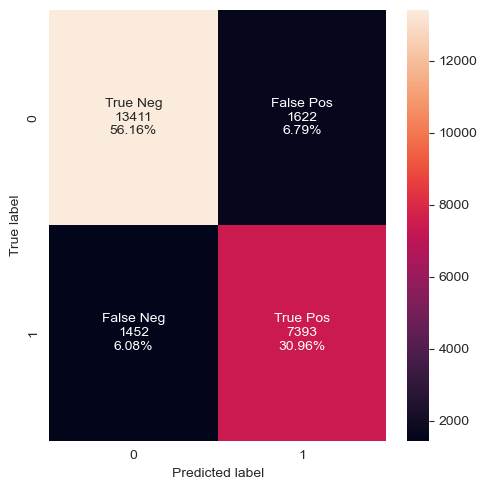

In [31]:
# matriz de confusión con el nuevo threshold
conf_matrix_with_opt_f1_score = confusion_matrix(y_test, y_pred)

print("\nMatriz de confusion:")

draw_confusion_matrix(conf_matrix_with_opt_f1_score)

Comparamos ambas matrices de confusion, la original y la nueva con el metodo de optimizacion de threshold y F1-score.

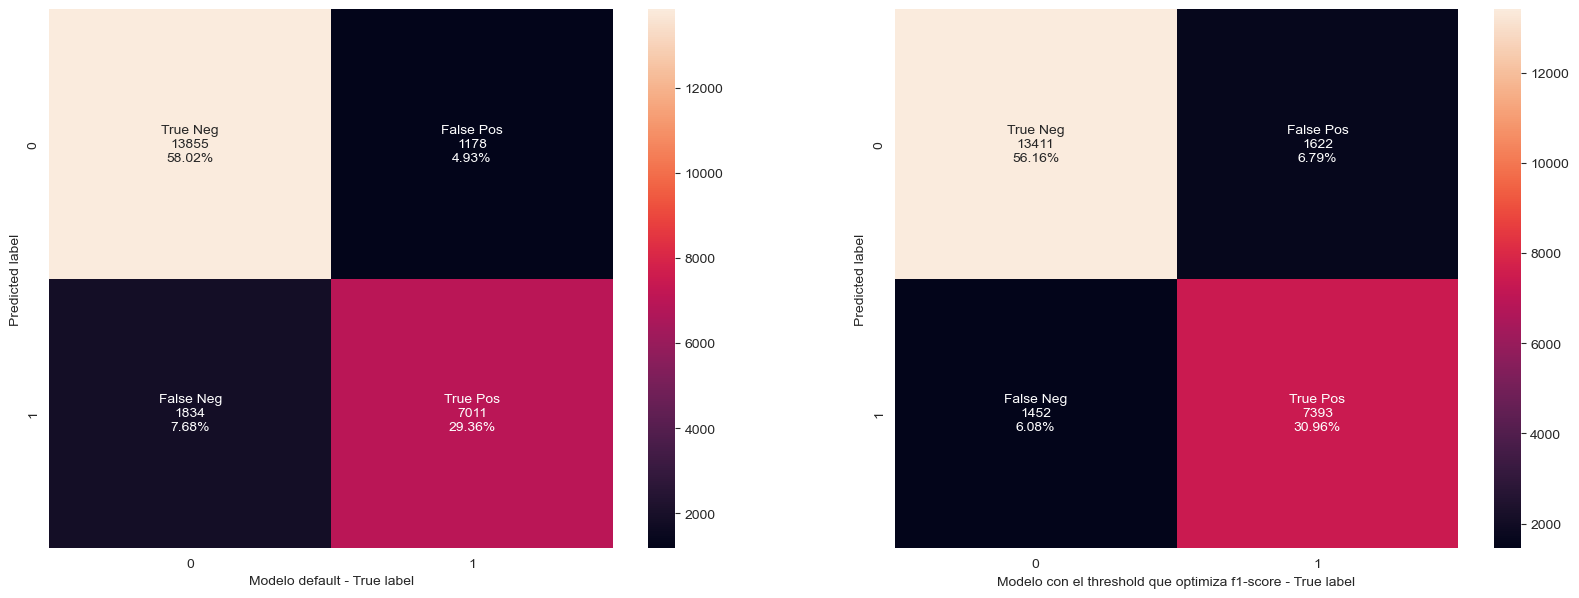

<Figure size 1000x500 with 0 Axes>

In [32]:
from src.draw_utils import draw_comparison_confusion_matrices

draw_comparison_confusion_matrices(
    confusion_1=conf_matrix,
    confusion_2=conf_matrix_with_opt_f1_score,
    confusion_matrix_1_name='Modelo default',
    confusion_matrix_2_name='Modelo con el threshold que optimiza f1-score'
)

Podemos obsevar que con el nuevo threshold se tiene un mejor desempeno con los falsos postivos, valores extremadamente importantes para el modelo. Por lo tanto es mejor utilizar el mdoelo con el threshold encotnrado que maximisa el f1-score.

### Grafico precision - recall

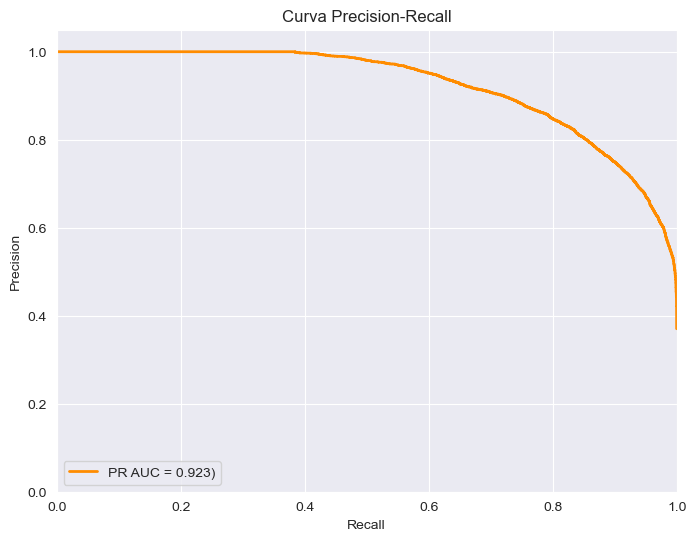

In [33]:
from draw_utils import draw_pr_auc # type: ignore


draw_pr_auc(
    y_test=y_test,
    y_prob=y_proba,
    g_title='Curva ROC - Cancelacion de reservacion'
)

Podemos observar que nuestro modelo a tratar de mejorar el Recall disminuye la precision. Por lo tanto, al tratar de mejorar la capacidad del modelo de identificar las personas que cancelaran la capacida de identificar las personas que no cancelan disminuira.

### Métricas de clasificación

In [34]:
# Métricas de clasificación
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     15033
           1       0.82      0.84      0.83      8845

    accuracy                           0.87     23878
   macro avg       0.86      0.86      0.86     23878
weighted avg       0.87      0.87      0.87     23878



# Estudio de las variables y sus importancias para el modelo

## Agrupamos las variables

Es necesario antes de hacer el estudio agrupar las variables ya que se utilizo el one hot encoder, por lo tanto las variables se encuentran separadas en distintas columnas.

In [35]:
# crear DataFrame con importancias
feature_importances = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': model.feature_importances_
})

In [36]:
feature_importances

,Feature,Importance
0,lead_time,0.005464
1,arrival_date_year,0.007308
2,arrival_date_week_number,0.001782
3,arrival_date_day_of_month,0.000999
4,stays_in_weekend_nights,0.002043
...,...,...
247,deposit_type_Refundable,0.000000
248,customer_type_Contract,0.004058
249,customer_type_Group,0.000000
250,customer_type_Transient,0.014784


In [37]:
# agrupar la importancia por la característica original
original_feature_importances = {}

# get the features
features = df_hotel.columns.tolist()
# remove is "is_canceled" porque no es una feature, es el target
features.remove('is_canceled')

# por cada columna de las que se codifico
for original_feature in features:
    # tomamos todas las columnas que contengan el nombre de la columna original
    cols = [col for col in X_train_final.columns if original_feature in col]

    # sumamos la importancia de todas las columnas tomadas anteriormente
    original_feature_importances[original_feature] = feature_importances[feature_importances['Feature'].isin(cols)]['Importance'].sum()

In [38]:
# transformamos el diccionario a un DataFrame
original_feature_importances_df = pd.DataFrame.from_dict({
    'Feature': original_feature_importances.keys(),
    'Importance': original_feature_importances.values()
})

# ordenar por importancia descendente
original_feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

In [39]:
original_feature_importances_df

,Feature,Importance
21,deposit_type,0.508613
12,country,0.139590
13,market_segment,0.082359
25,required_car_parking_spaces,0.053012
18,reserved_room_type,0.025919
19,assigned_room_type,0.025874
23,customer_type,0.024219
16,previous_cancellations,0.023320
3,arrival_date_month,0.020398
26,total_of_special_requests,0.016223


In [40]:
# verificamos que la suma de todas las importancias de 1
print(f'Suma de todas las importancias: {original_feature_importances_df['Importance'].sum()}')

Suma de todas las importancias: 1.0


Podemos observar que el modelo posee buenas métricas con valores de precision, recall y f1-score cercanos por lo tanto parece no existir un alto overfitting.

## Estudio de la importancia de cada variable

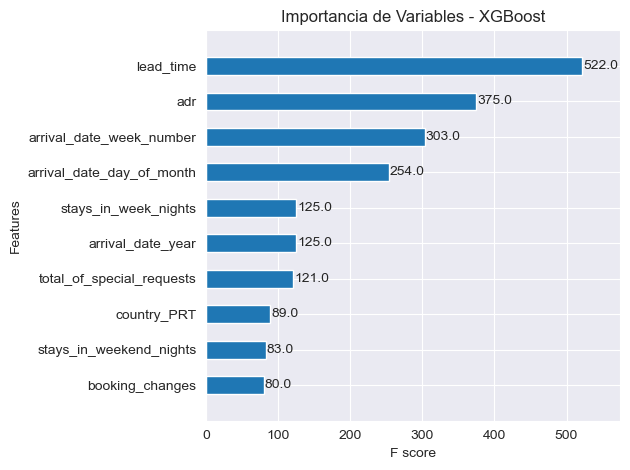

In [41]:
#Interpretación del modelo – Importancia de Variables
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Visualización de importancia de las características
plot_importance(model, max_num_features=10, height=0.5)
plt.title("Importancia de Variables - XGBoost")
plt.tight_layout()
plt.show()

## Interpretación de Importancia de Variables

Las top 3 variables que más influyen en la predicción de cancelaciones son:

1. lead_time (Tiempo entre reserva y llegada) → cuanto mayor, más riesgo de cancelación.
2. adr	(Precio medio por noche) → precios altos pueden ser más susceptibles a cancelación.
3. country	(Origen del huésped) → posiblemente refleja patrones culturales o restricciones.

In [42]:
# mostramos la tabla de importancias
original_feature_importances_df

,Feature,Importance
21,deposit_type,0.508613
12,country,0.139590
13,market_segment,0.082359
25,required_car_parking_spaces,0.053012
18,reserved_room_type,0.025919
19,assigned_room_type,0.025874
23,customer_type,0.024219
16,previous_cancellations,0.023320
3,arrival_date_month,0.020398
26,total_of_special_requests,0.016223


## Guardamos la importancia de las features


In [43]:
# definimos las rutas
ruta_pre_procesado = '../data/processed/feature_importances.csv'
ruta_pre_procesado_original = '../data/processed/feature_importances_original.csv'

try:
    # save the DataFrame to the file for future use
    feature_importances.to_csv(ruta_pre_procesado, index=False, sep=save_csv_params["sep"])
    original_feature_importances_df.to_csv(ruta_pre_procesado_original, index=False, sep=save_csv_params["sep"])

    print(f"Data saved to file: {ruta_pre_procesado}")
    print(f"Data saved to file: {ruta_pre_procesado_original}")

except Exception as e:
    print(f"Error saving data to {ruta_pre_procesado} with error: {e}")
    print(f"Error saving data to {ruta_pre_procesado_original} with error: {e}")

Data saved to file: ../data/processed/feature_importances.csv
Data saved to file: ../data/processed/feature_importances_original.csv


 Hallazgos clave de la importancia de variables:

| Variable                      | Interpretación estratégica para churn                                                                                                       |
|-------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------|
| `deposit_type`                | La más influyente. Segun el tipo depósito, el cliente puede cancelar sin penalización. Esto **debería revisarse** como política de negocio. |
| `country`                     | El pais de origen de la persona que realiza la reserva afecta en gran medida si la reserva es o no cancelada.                               |
| `required_car_parking_spaces` | Clientes que requieren estacionamiento parecen más comprometidos con su estadía.                                                            |
| `previous_cancellations`      | Los que han cancelado antes, tienden a hacerlo de nuevo. Perfil de cliente riesgoso.                                                        |
| `market_segment`              | El canal de origen de la reserva afecta la tasa de cancelación. Canales online (OTA) suelen tener más cancelaciones.                        |
| `total_of_special_requests`   | Clientes con solicitudes especiales tienden a ser más fieles.                                                                               |

En cambio, variables como meal, distribution_channel, y assigned_room_type tienen bajo impacto predictivo en este modelo.

## Interpretacion SHAP

 98%|===================| 23398/23878 [00:48<00:00]        

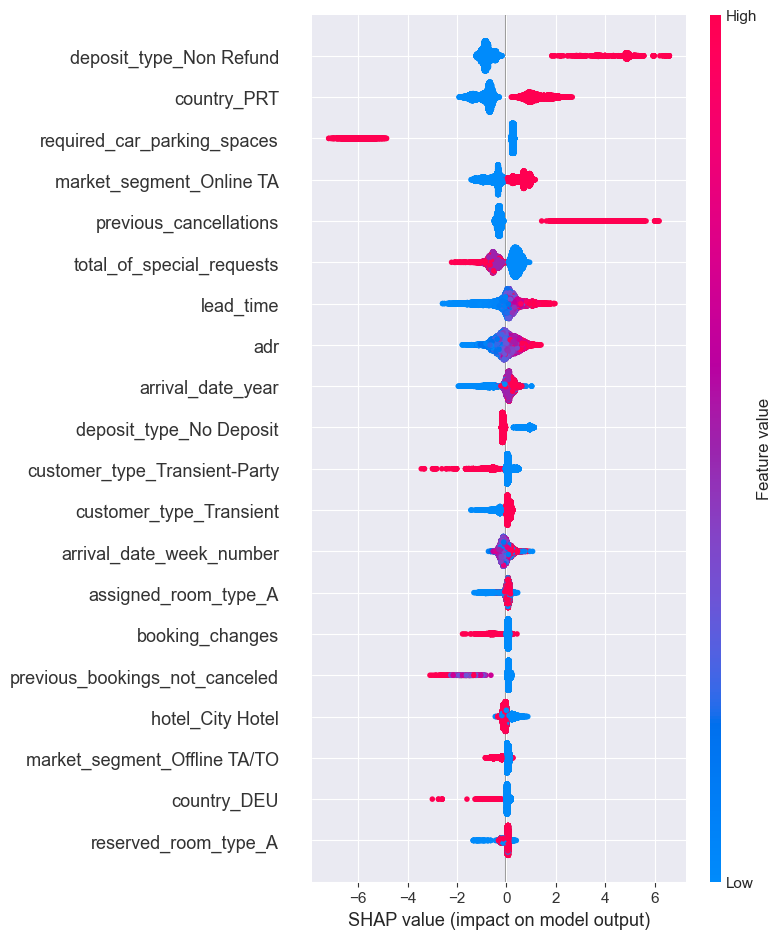

In [44]:
import shap

# interpretación SHAP
explainer = shap.Explainer(model, X_train_final)
shap_values = explainer(X_test_final)

# grafico de los valores SHAP
shap.summary_plot(shap_values, X_test_final)

La variable con mas importancia que podemos ver en este gráfico (deposit_type Non Refund), es la que tiene mas impacto en el modelo, es decir que los depositos no reembolsables son los que más influyen en la predicción de cancelaciones. Esto tiene sentido, ya que si un cliente no puede recuperar su dinero, es menos probable que cancele su reserva.

Es importante denotar que en SHAP no poseemos una forma de estudiar las variables como una luego del proceso de one-hot-encoding. Sin embargo, podemos analizar los valores SHAP individuales de las columnas one-hot correspondientes para inferir la importancia general de la característica original. Si todas las columnas one-hot de una característica tienen valores SHAP consistentemente grandes, entonces la característica original es importante.

# Conclusiones del modelo de cancelación (churn) con XGBoost

**1. Variables más influyentes:**
- `deposit_type`: La política de depósito es el factor más determinante. Las reservas sin depósito tienen alta tasa de cancelación.
- `required_car_parking_spaces`: Los clientes que solicitan estacionamiento parecen estar más comprometidos.
- `previous_cancellations`: El historial del cliente predice comportamiento futuro: quienes ya cancelaron, lo harán de nuevo.

**2. Implicancias de negocio:**
- Reforzar políticas de depósito mínimo o penalización en segmentos con alta cancelación.
- Priorizar promociones hacia segmentos con baja propensión a cancelar (p.ej., quienes hacen solicitudes especiales).
- Evaluar y controlar canales de reserva con alto churn (p.ej., ciertos `market_segment` o `distribution_channel`).

**3. Recomendaciones adicionales:**
- Implementar alertas tempranas para reservas con alto `lead_time` y sin depósito.
- Ofrecer beneficios adicionales a clientes frecuentes que nunca han cancelado (`previous_bookings_not_canceled` alto).
- Reentrenar el modelo regularmente para adaptarse a cambios de comportamiento por estacionalidad o eventos externos.

---

✅ El modelo XGBoost ofrece una buena capacidad predictiva y guía acciones concretas para reducir la tasa de cancelaciones.


# Guardamos el modelo default

In [45]:
from pickle import dump

model_file_name = '../models/default_model.pkl'

with open(model_file_name, "wb") as f:
    dump(model, f, protocol=5)